### All SPARQL Requests have been built with help from Wikidata Query Builder

In [50]:
%pip install sparqlwrapper
%pip install spacy 
%pip install shapely
%pip install geopy
%pip install geopandas
%pip install pandas
%pip install matplotlib
#install the nlp model used for spaCy (this is over 10 MB)
!python -m spacy download en_core_web_lg

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


                                              0.0/587.7 MB ? eta -:--:--
                                              0.2/587.7 MB 6.3 MB/s eta 0:01:34
                                             1.1/587.7 MB 11.9 MB/s eta 0:00:50
                                             3.1/587.7 MB 21.9 MB/s eta 0:00:27
                                             4.1/587.7 MB 26.3 MB/s eta 0:00:23
                                             6.7/587.7 MB 28.6 MB/s eta 0:00:21
                                             8.3/587.7 MB 31.2 MB/s eta 0:00:19
                                             8.7/587.7 MB 26.4 MB/s eta 0:00:22
                                            11.3/587.7 MB 38.6 MB/s eta 0:00:15
                                            13.1/587.7 MB 38.5 MB/s eta 0:00:15
                                            15.1/587.7 MB 40.9 MB/s eta 0:00:14
     -                                      17.0/587.7 MB 38.5 MB/s eta 0:00:15
     -                                      18.


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


You will also have to download the geojson file found at this url https://nihr.opendatasoft.com/explore/dataset/westminster-parliamentary-constituencies/export/?flg=en-gb

In [3]:
import spacy
from SPARQLWrapper import SPARQLWrapper, JSON
import json
from geopy.geocoders import Nominatim
from collections import Counter
from shapely import Point, geometry
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [75]:
# Set the SPARQL endpoint URL and create the wrapper
sparql_endpoint = "https://api.parliament.uk/sparql/"
sparql = SPARQLWrapper(sparql_endpoint)

# Broad query gathering all questions in the time period the person asking, and that persons MNIS ID
sparql_query = """
SELECT *
WHERE {
  ?question <https://id.parliament.uk/schema/writtenQuestionIndexingAndSearchUin> ?qnum .
  ?person <https://id.parliament.uk/schema/askingPersonHasQuestion> ?question .
  ?question <https://id.parliament.uk/schema/questionText> ?text .
  ?question <https://id.parliament.uk/schema/questionAskedAt> ?date .
  ?person <https://id.parliament.uk/schema/mnisId> ?id
  FILTER (?date >= "2023-01-01+00:00"^^xsd:dateTime && ?date < "2023-10-01+00:00"^^xsd:dateTime)
}
"""

# Perform the query and receive the results
sparql.setQuery(sparql_query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

endpoint_url = "https://query.wikidata.org/sparql"
sparql = SPARQLWrapper(endpoint_url)

# Query to get all cities that are within the UK
query = """
  SELECT DISTINCT ?city ?cityLabel WHERE {
  ?city wdt:P31 wd:Q515;
        wdt:P17 wd:Q145.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}"""

# Perform the query and receive the results
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
cities = sparql.query().convert()

# Query to get the name of all cosntituencies
query = """
  SELECT DISTINCT ?const ?constLabel WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  ?sub wdt:P279 wd:Q2064521.
  ?const wdt:P31 ?sub
}
"""

# Perform the query and receive the results
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
consts = sparql.query().convert()

# Get all the country names
query = """
  SELECT DISTINCT ?item ?itemLabel WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE], en". }
  {
    SELECT DISTINCT ?item WHERE {
      ?item p:P31 ?statement0.
      ?statement0 (ps:P31/(wdt:P279*)) wd:Q6256.
    }
  }
}
"""

# Perform the query and receive the results
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
countries = sparql.query().convert()

In [76]:
cities_list = []
for city in cities["results"]["bindings"]:
    new_city = {
        "cityName": city["cityLabel"]["value"],
        "cityURI": city["city"]["value"]
    }
    cities_list.append(new_city)

consts_list = []
for const in consts["results"]["bindings"]:
    new_const = {
        "constName": const["constLabel"]["value"],
        "constURI": const["const"]["value"]
    }
    consts_list.append(new_const)

country_list = []
for country in countries["results"]["bindings"]:
    country_list.append(country["itemLabel"]["value"])

### You don't need to run the code cell below, all results with places are saved to a JSON file called <span style="color:green">**results_with_places.json**</span>
### Similarly, the rest of the notebook contains checkpoints where you can download my results at that point. If you have run the code yourself, make sure you upload the results at each checkpoint and then load them. Code following a checkpoint will use the name of the loaded information.
#### <span style="color:#e0434b">**The NER process takes ~6 minutes and is required if you would like to test the visualisations at the end. Any cells requiring all_results will not work. The json file containing all_results is over 10 MB and cannot be included**</span>
The code below uses a pretrained NER model to tag all the question texts for words or phrases that are geopolitical entities(GPE) or locations(LOC) it then stores all these segments in a list withith the dictionary called "locations

#### The code below contains some elements of and is inspired by https://stackoverflow.com/questions/52686159/how-to-extract-the-location-name-country-name-city-name-tourist-places-by-usi

In [17]:
nlp = spacy.load("en_core_web_lg") #From the code source

In [18]:
# List to store results with place names and identifiable geographical features
results_with_places = []
all_results = []

for result in results["results"]["bindings"]:
    text = result["text"]["value"]

    # Process the text with spaCy NER
    doc = nlp(text)

    # Extract and store named entities with the label "GPE" (Geopolitical Entity)
    place_names = [ent.text for ent in doc.ents if ent.label_ == "GPE"] #Taken from source

    # Extract and store other identifiable geographical features
    geo_features = [token.text for token in doc if token.ent_type_ == "LOC" and token.text.lower() not in place_names]#Taken from source

    # Search for any UK cities in the text
    uk_cities = []
    for city in cities_list:
        if city["cityName"] in text:
            uk_cities.append(city["cityName"])

   # Search for any UK constituencies in the text 
    uk_consts = []
    for const in consts_list:
        if const["constName"] in text:
            uk_consts.append(const["constName"])

    # Combine place names and identifiable geographical features
    locations = place_names + geo_features + uk_cities + uk_consts

    # Remove any countries from the locations
    if locations:
        for loc in locations:
            if loc in country_list or loc == "UK":
                locations.remove(loc)

    # Check if any locations are found
    if locations:
        # Store the entire result when locations are found
        result_with_places = {
            "question": result["question"]["value"],
            "qnum": result.get("qnum", {}).get("value", ""),
            "person": result.get("person", {}).get("value", ""),
            "MNIS": result.get("id", {}).get("value", ""),
            "text": text,
            "date": result.get("date", {}).get("value", ""),
            "locations": locations
        }

        results_with_places.append(result_with_places)
    
    # Create a list of all results regardless of if they contain locations or not
    result = {
            "question": result["question"]["value"],
            "qnum": result.get("qnum", {}).get("value", ""),
            "person": result.get("person", {}).get("value", ""),
            "MNIS": result.get("id", {}).get("value", ""),
            "text": text,
            "date": result.get("date", {}).get("value", ""),
        }

    all_results.append(result)


# <span style="color:#e0434b">**Any time you see these save and load file cells you have to run the load cell even if you have run the code up to that point**</span>

In [19]:
# Save results to a JSON file
output_file_path = "results_with_places.json"
with open(output_file_path, 'w') as json_file:
    json.dump(results_with_places, json_file, indent=2)

# Save results to a JSON file THIS WILL RESULT IN AN ERROR IF YOU HAVE NOT RUN THE ABOVE CODE
output_file_path = "all_results.json"
with open(output_file_path, 'w') as json_file:
    json.dump(all_results, json_file, indent=2)

In [4]:
# Load that JSON file
with open("results_with_places.json", 'r') as json_file:
    loaded_results = json.load(json_file)

# Load that JSON file THIS WILL RESULT IN AN ERROR IF YOU HAVE NOT RUN THE NER
with open("all_results.json", 'r') as json_file:
    all_loaded_results = json.load(json_file)

In [21]:
sparql_endpoint = "https://query.wikidata.org/sparql"
sparql = SPARQLWrapper(sparql_endpoint)
# query wikidata to get the MNIS and Constituency of every member of the current parliament
sparql_query = """
SELECT DISTINCT ?item ?id ?district ?districtLabel WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  ?item wdt:P39 wd:Q77685926.
  ?item wdt:P10428 ?id.
  ?item p:P39 [pq:P768 ?district;
                pq:P580 ?date].
    FILTER(YEAR(?date) = 2019)
}"""

sparql.setQuery(sparql_query)
sparql.setReturnFormat(JSON)
constituencies = sparql.query().convert()

# Get constituencies by MNIS ID
constituencies_list = []
for entry in constituencies["results"]["bindings"]:
    dict_entry = {
        "MNIS": entry["id"]["value"],
        "ConstituencyLabel": entry["districtLabel"]["value"],
        "ConstituencyURI": entry["district"]["value"]
    }
    constituencies_list.append(dict_entry)

In [22]:
merged_list = []
for result in loaded_results:
    mnis_value = result['MNIS']

    # Merge the two lists based on MNIS
    matching = next((const for const in constituencies_list if const['MNIS'] == mnis_value), None)
    if matching is not None:
        merged_dict = {**result, **matching}
        merged_list.append(merged_dict)

for result in merged_list:
    result["locations"] = list(dict.fromkeys(result["locations"]))        

In [23]:
# THIS WILL RESULT IN AN ERROR IF YOU HAVE NOT RUN THE NER
all_merged_list = [] 
for result in all_loaded_results:
    mnis_value = result['MNIS']
    # Merge the two lists based on MNIS
    matching = next((const for const in constituencies_list if const['MNIS'] == mnis_value), None)
    if matching is not None:
        merged_dict = {**result, **matching}
        all_merged_list.append(merged_dict)

In [98]:
output_file_path = "results_with_constituencies.json"
with open(output_file_path, 'w') as json_file:
    json.dump(merged_list, json_file, indent=2)

output_file_path = "all_results_with_constituencies.json" # THIS WILL RESULT IN AN ERROR IF YOU HAVE NOT RUN CODE ABOVE
with open(output_file_path, 'w') as json_file:
    json.dump(all_merged_list, json_file, indent=2)

In [5]:
with open("results_with_constituencies.json", 'r') as json_file:
    loaded_results_constituencies = json.load(json_file)

with open("all_results_with_constituencies.json", 'r') as json_file: #THIS WILL RESULT IN ERROR IF YOU HAVE NOT RUN CODE ABOVE
    all_merged_list = json.load(json_file)

### <span style="color:#e0434b">**This code block uses a geoencoder to get the coordinates of all of the places mentioned in the questions this can take up to 15 minutes. The results are saved in coordinates.json loading them will allow the rest of the code to run**</span>
#### Code below was inspired by https://www.tutorialspoint.com/how-to-get-the-longitude-and-latitude-of-a-city-using-python

In [26]:
# Create a list of all locations in the questions
locations_full = []
for result in loaded_results_constituencies:
    for loc in result["locations"]:
        if loc not in locations_full:
            locations_full.append(loc)
            
# Create a geocoder agent which returns coordinates from place names
geoen = Nominatim(user_agent="CMHSS") 
locations_dicts = []

for location in locations_full:
    try:
        location_data = geoen.geocode(location) # Runs the geocoder for that location Comes from source
        if location_data:
            latitude, longitude = location_data.latitude, location_data.longitude
            new_loc = { #stores the latitude and longitude in a dictionary object
                "name": location,
                "coordinates": [latitude,longitude]
            }
            locations_dicts.append(new_loc)
    except Exception as e:
        print(f"Error geocoding {location}: {str(e)}")
    

Error geocoding 2022/23.</p: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=2022%2F23.%3C%2Fp&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error geocoding the City of York Council: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=the+City+of+York+Council&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


In [27]:
output_file_path = "coordinates.json"
with open(output_file_path, 'w') as json_file:
    json.dump(locations_dicts, json_file, indent=2)

In [6]:
with open("coordinates.json", 'r') as json_file:
    loaded_coords = json.load(json_file)

In [29]:
# Match up every coordinate to its appropriate place and add to the master list of results as a new key,value pair in dict
for entry in loaded_results_constituencies:
    coords = []
    for loc in entry["locations"]:
        for coord in loaded_coords:
            if coord["name"] == loc:
                coords.append(coord)
    entry["coordinates"] = coords

In [30]:
output_file_path = "results_with_coordinates.json"
with open(output_file_path, 'w') as json_file:
    json.dump(loaded_results_constituencies, json_file, indent=2)

In [7]:
with open("results_with_coordinates.json", 'r') as json_file:
    loaded_results_coords = json.load(json_file)

In [32]:
max_coords = [60.87, 49.956739,1.762973,-8.17751] # Coordinates of the most extreme points of UK lat:NS long:EW
# Cull any coordinates outside of the UK bounds
for result in loaded_results_coords:
    for coord in result["coordinates"]:
        if coord["coordinates"][0] > max_coords[0] or coord["coordinates"][0] < max_coords[1]:
            result["coordinates"].remove(coord)
        elif coord["coordinates"][1] > max_coords[2] or coord["coordinates"][1] < max_coords[3]:
            result["coordinates"].remove(coord)
    if len(result["coordinates"]) == 0:
        loaded_results_coords.remove(result)

In [33]:
output_file_path = "results_with_coordinates_culled.json"
with open(output_file_path, 'w') as json_file:
    json.dump(loaded_results_coords, json_file, indent=2)

In [8]:
with open("results_with_coordinates_culled.json", 'r') as json_file:
    loaded_results_coords_culled = json.load(json_file)

In [9]:
# Get all the remaining entries coordinates and constituency names
remaining = []
for entry in loaded_results_coords_culled:
    for i in range(len(entry["coordinates"])):
        remaining.append(entry["coordinates"][i])

### <span style="color:#e0434b">**This code cell requires you to have downloaded the geojson file from the link at the top of the notebook and placed it into the same folder as this notebook**</span>


In [10]:
with open('westminster-parliamentary-constituencies.geojson') as f:
    geojson_data = json.load(f)

In [11]:
for result in loaded_results_coords_culled:
    result["Text_Constituencies"] = []

#### The following code cell is inspired by and adapted from https://stackoverflow.com/a/20793808

In [12]:
# Iterate through polygons and check for containment
for feature in geojson_data["features"]:
    polygon = geometry.shape(feature["geometry"])
    for result in loaded_results_coords_culled:
        coords_list = result["coordinates"]
        consts_list=[]
        for coord_obj in coords_list:
            coords = coord_obj["coordinates"]
            point_object = geometry.Point([coords[1],coords[0]])
            if point_object.within(polygon):
                result["Text_Constituencies"].append(feature['properties']['pcon22nm'])

In [13]:
self_references = []
# Gather every self referential question
for result in loaded_results_coords_culled:
    if result["ConstituencyLabel"] in result["Text_Constituencies"]:
        self_references.append(result)

In [76]:
print(len(self_references))

871


In [14]:
self_counts_list = []
for result in self_references:
    result["Text_Constituencies"] = list(set(result["Text_Constituencies"]))
    self_counts_list.append(result["ConstituencyLabel"])

counts_list = []
for result in all_merged_list:
    counts_list.append(result["ConstituencyLabel"])
    

In [15]:
# Count occurrences
item_counts = Counter(self_counts_list)

all_counts = Counter(counts_list)

In [47]:
gdf = gpd.read_file('westminster-parliamentary-constituencies.geojson')

In [99]:
ratio_gdf = gpd.read_file('westminster-parliamentary-constituencies.geojson')

In [17]:
constituencies_from_gdf = gdf["pcon22nm"].values.tolist()

In [34]:
counts_by_const = []
for const in constituencies_from_gdf:
    new_const = {
        "name": const,
        "self": 0,
        "total": 0,
        "ratio": 0
    }
    counts_by_const.append(new_const)
for item, count in item_counts.items():
    for const in counts_by_const:
        if const["name"] == item:
            const["self"] = count

for item, count in all_counts.items():
    for const in counts_by_const:
        if const["name"] == item:
            const["total"] = count

for const in counts_by_const:
    if const["total"] > 0:
        const["ratio"] = const["self"]/const["total"]

In [35]:
output_file_path = "final_counts.json"
with open(output_file_path, 'w') as json_file:
    json.dump(counts_by_const, json_file, indent=2)

In [38]:
with open("final_counts.json", 'r') as json_file:
    counts_by_const = json.load(json_file)

In [48]:
constituencies_df = pd.DataFrame(counts_by_const)

# Merge the GeoDataFrame with the DataFrame containing the float values
gdf = gdf.merge(constituencies_df, left_on='pcon22nm', right_on='name', how='left')

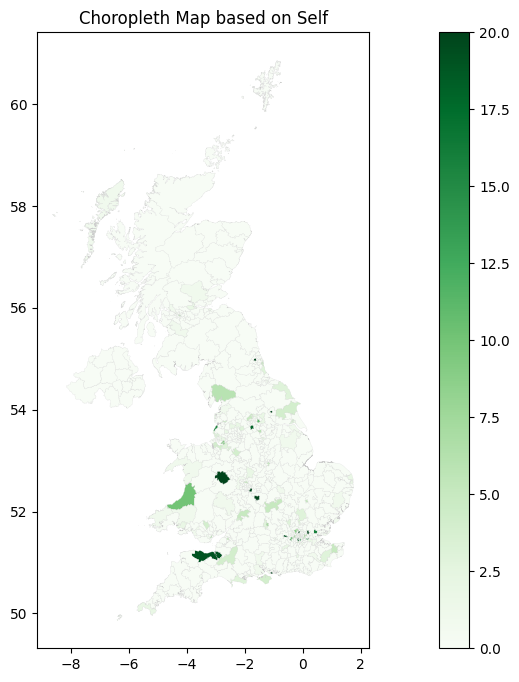

In [83]:
# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
# gdf.plot(column='ratio', cmap='OrRd', linewidth=0.1, ax=ax, edgecolor='0.8', legend=True,vmax=.4)
# ax.set_title('Choropleth Map based on Ratio')
# gdf.plot(column='total', cmap='Blues', linewidth=0.1, ax=ax, edgecolor='0.8', legend=True,vmax=200)
# ax.set_title('Choropleth Map based on Total')
gdf.plot(column='self', cmap='Greens', linewidth=0.1, ax=ax, edgecolor='0.8', legend=True,vmax = 20)
ax.set_title('Choropleth Map based on Self')
plt.show()

In [73]:
# Sorting the list of dictionaries in descending order based on the "ratio" key
sorted_ratio = sorted(counts_by_const, key=lambda x: x["ratio"], reverse=True)
sorted_self = sorted(counts_by_const, key=lambda x: x["self"], reverse=True)
sorted_total = sorted(counts_by_const, key=lambda x: x["total"], reverse=True)

In [163]:
# display(pd.DataFrame(sorted_ratio).head(10))
display(pd.DataFrame(sorted_self).head(20))
# display(pd.DataFrame(sorted_total))

,name,self,total,ratio
0,York Central,113,1524,0.074147
1,Solihull,98,1008,0.097222
2,Portsmouth South,39,401,0.097257
3,Newcastle upon Tyne Central,32,415,0.077108
4,Battersea,29,237,0.122363
5,Warwick and Leamington,25,205,0.121951
6,Shrewsbury and Atcham,24,133,0.180451
7,Hornsey and Wood Green,20,312,0.064103
8,Romford,20,411,0.048662
9,Bridgwater and West Somerset,19,27,0.703704


In [145]:
df_ratio = pd.DataFrame(sorted_ratio)
large_ratio = df_ratio[df_ratio['total']>30]
large_ratio_noself = large_ratio[large_ratio['self'] == 0]
large_ratio_self = large_ratio[large_ratio['self']>0]
# display(large_ratio.tail(10))
small_ratio = df_ratio[df_ratio['total']<=30]
small_ratio_culled = small_ratio[small_ratio['total']>0]
small_ratio_noself = small_ratio_culled[small_ratio_culled['self'] == 0]
small_ratio_self = small_ratio_culled[small_ratio_culled['self'] > 0]
display(large_ratio)
print(large_ratio_self['ratio'].median())

,name,self,total,ratio
11,Halton,9,32,0.281250
12,Dulwich and West Norwood,15,56,0.267857
15,Cardiff Central,7,32,0.218750
20,Shrewsbury and Atcham,24,133,0.180451
27,Huddersfield,18,147,0.122449
...,...,...,...,...
626,Swansea West,0,119,0.000000
629,Orkney and Shetland,0,44,0.000000
632,Torfaen,0,47,0.000000
636,Arfon,0,84,0.000000


0.0425531914893617


In [79]:
len(self_references)/len(all_merged_list)

0.03245519245817342

In [89]:
print(len(constituencies_df[constituencies_df['total'] == 0]))

294


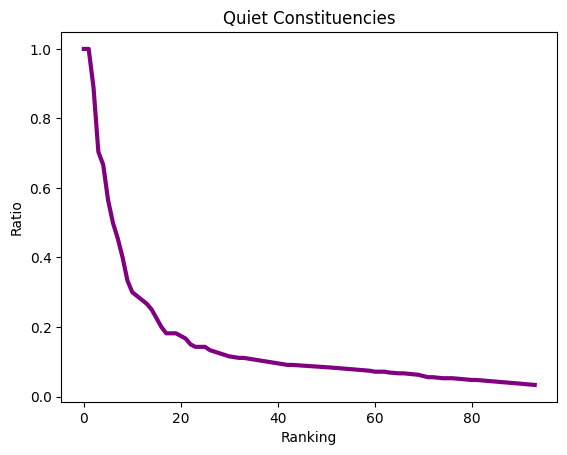

In [155]:
small_ratio_self['ratio'].plot(color='purple', linewidth = 3)
plt.title('Quiet Constituencies')
plt.xlabel('Ranking')
plt.ylabel('Ratio')
plt.show()

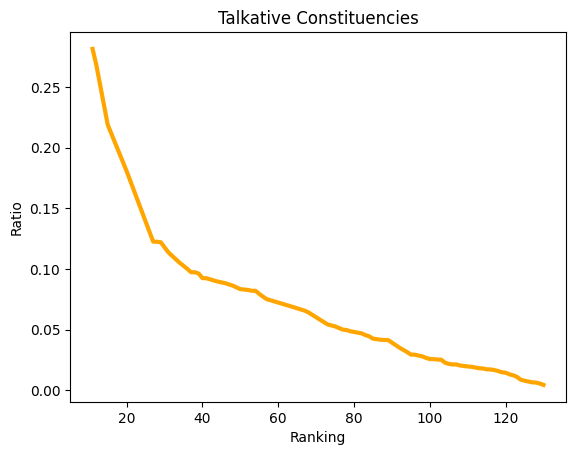

In [156]:
large_ratio_self['ratio'].plot(color='orange', linewidth = 3)
plt.title('Talkative Constituencies')
plt.xlabel('Ranking')
plt.ylabel('Ratio')
plt.show()